In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import psycopg2
from pmdarima import auto_arima
import statsmodels as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm import tqdm

In [2]:
!pip install pyarrow

Defaulting to user installation because normal site-packages is not writeable


# Read data for the location of Berlin and visualize the time series

In [357]:
try_df= pd.read_parquet(r'challenge-data/truth/2022-01-09_BL_cases.parquet')
try_df.head(), try_df.tail()

(   location      target  value
 0       1.0  2020-02-01    0.0
 1       1.0  2020-02-02    0.0
 2       1.0  2020-02-03    0.0
 3       1.0  2020-02-04    0.0
 4       1.0  2020-02-05    0.0,
        location      target       value
 11323      16.0  2022-01-04  415.378092
 11324      16.0  2022-01-05  384.815471
 11325      16.0  2022-01-06  359.629607
 11326      16.0  2022-01-07  343.923816
 11327      16.0  2022-01-08  350.715510)

In [248]:
df_train_BL = pd.read_parquet(r'challenge-data/truth/2022-09-04_BL_cases.parquet')
df_train_BL = df_train_BL[df_train_BL.location==11]
df_train_BL.rename(columns = {'target':'day'}, inplace=True)


df_test_BL = pd.read_csv('challenge-data/evaluation/2022-10-02_BL_cases.csv', parse_dates=True)
df_test_BL = df_test_BL[df_test_BL.location==11]
#df_test_BL = df_test_BL.tail(28).reset_index()
df_test_BL.rename(columns = {'target':'day'}, inplace=True)
#df_test_BL= df_test_BL.drop(['index'], axis=1)
df_test_BL.day = pd.to_datetime(df_test_BL.day)
type(df_test_BL.day.iloc[0])

pandas._libs.tslibs.timestamps.Timestamp

In [403]:
df_train1 = df_train_BL.loc[df_train_BL.day < pd.Timestamp('2022-01-09')].reset_index().set_index('day').drop(['index','location'], axis=1)
df_test1 = df_test_BL.query("day>='2022-1-9' and day<='2022-2-5'").reset_index().set_index('day').drop(['index','location'], axis=1)
df_train1

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


,value
day,
2020-02-01,0.000000
2020-02-02,0.000000
2020-02-03,0.000000
2020-02-04,0.000000
2020-02-05,0.000000
...,...
2022-01-04,418.521608
2022-01-05,501.461755
2022-01-06,599.685379


In [89]:
df1 = pd.read_csv('challenge-data/truth/2021-05-16_LK_cases.csv', parse_dates=True)
df_train = pd.read_parquet(r'challenge-data/truth/2022-09-04_LK_cases.parquet')

df_test = pd.read_csv('challenge-data/evaluation/2022-10-02_LK_cases.csv', parse_dates=True)
df_train.rename(columns = {'target':'day'}, inplace=True)
#df_train = df_train.set_index('day')
#df_train = df_train.groupby('location')
#df_test = df_test.set_index('target')
df_test=df_test.tail(28)
df_train = df_train[df_train['location']==16077]
df_train.head(), df_train.tail(), len(df_train)
#df_test.head()

(        location         day  value
 387450   16077.0  2020-02-01    0.0
 387451   16077.0  2020-02-02    0.0
 387452   16077.0  2020-02-03    0.0
 387453   16077.0  2020-02-04    0.0
 387454   16077.0  2020-02-05    0.0,
         location         day       value
 388390   16077.0  2022-08-29  227.488795
 388391   16077.0  2022-08-30  228.620580
 388392   16077.0  2022-08-31  218.434515
 388393   16077.0  2022-09-01  234.279506
 388394   16077.0  2022-09-02  182.217393,
 945)

In [117]:
df_test.rename(columns = {'target':'day'}, inplace=True)
#df_test=df_test.reset_index()
df_test=df_test.drop(['level_0', 'index'], axis=1)
df_test

,location,day,value
0,16077,2022-09-03,212.775590
1,16077,2022-09-04,201.457739
2,16077,2022-09-05,199.194169
3,16077,2022-09-06,182.217393
4,16077,2022-09-07,196.930599
5,16077,2022-09-08,177.690253
6,16077,2022-09-09,189.008104
7,16077,2022-09-10,186.744533
8,16077,2022-09-11,202.589524
9,16077,2022-09-12,185.612748


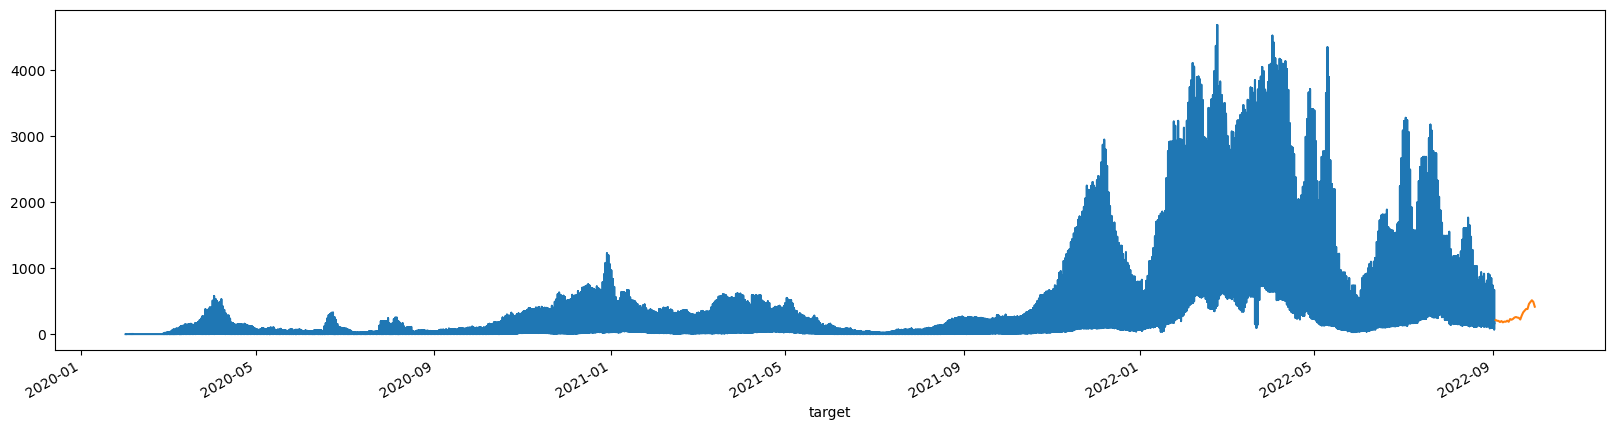

In [15]:
df_train.value.plot(figsize=(20,5))
df_test.value.plot()
df_test, df_train = df_test.drop('location', axis=1), df_train.drop('location', axis=1)

# **Split in train and test data**  

470
            value
target           
2020-02-01    0.0
2020-02-02    0.0
2020-02-03    0.0
2020-02-04    0.0
2020-02-05    0.0
                 value
target                
2021-03-17  114.261001
2021-03-18  123.070844
2021-03-19  122.002985
2021-03-20  126.274424
2021-03-21  132.414618
410 60


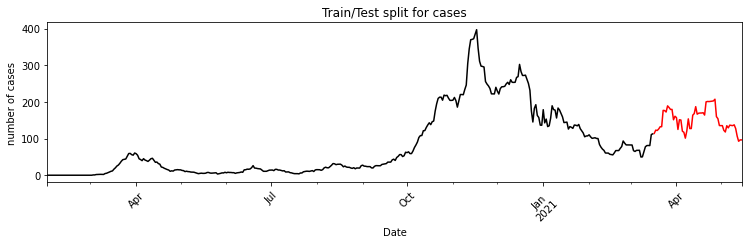

In [5]:
plt.rcParams["figure.figsize"] = [10.50, 3.50]
plt.rcParams["figure.autolayout"] = True

#df.target=pd.to_datetime(df['target'])
print(len(df1))
#print(df1.tail())

# train = df[df.target<datetime(2021, 4, 17)]
# test = df[df.target>datetime(2021, 4, 17)]

train = df1.iloc[:410]
test = df1.iloc[410:]
print(train.head())
print(test.head())
print(len(train), len(test))
train.value.plot(color='black')
test.value.plot(color='red')
plt.ylabel('number of cases')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for cases")
plt.show()



# **1. Perform ARIMA regression for this time series data**

In [29]:
result = auto_arima(combined_df.value, m=12, seasonal=True,
                      start_p=0, start_q=0, max_order=4, test='adf',error_action='ignore',  
                           suppress_warnings=True,
                      stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=3017.010, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=3022.740, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3001.393, Time=0.12 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3003.605, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=3021.072, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=3005.631, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=2992.584, Time=0.31 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=2993.853, Time=0.41 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=2998.704, Time=0.22 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=3011.361, Time=0.19 sec
 ARIMA(2,1,0)(2,0,0)[12] intercept   : AIC=2993.448, Time=0.31 sec
 ARIMA(1,1,1)(2,0,0)[12] intercept   : AIC=2993.792, Time=0.49 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=2992.001, Time=0.33 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=3001.826, Time=0.15 sec
 ARIMA(0,1,1)(2,0,1

In [30]:
model = SARIMAX(combined_df['value'], order=(3,1,5))
result = model.fit()

C:\Users\nishant.nigam\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nishant.nigam\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [31]:
forecast=model.predict(n_periods=60, return_conf_int=True)

TypeError: predict() missing 1 required positional argument: 'params'

TypeError: index type not supported

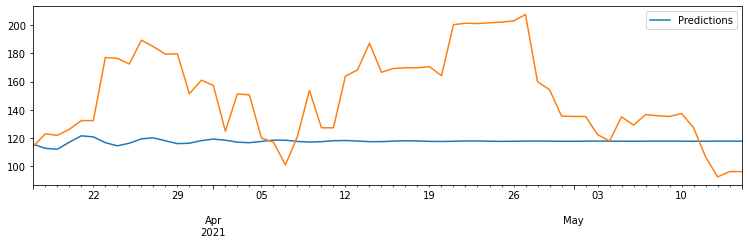

In [42]:
start = len(train)
end = len(train)+len(test)-1

pred = result.predict(start=start, end=end, typ='levels', dynamic=False).rename('Predictions')

#test.value.plot()
pred.plot(legend=True)
combined_df_test.value.plot(legend=True)
plt.show()

print(len(pred))
print(len(combined_df_test.values))

# **2. Perform Linear Regression for the time series**

r =  0.6433958984441368 
 p =  2.831946327349688e-56 
 s =  0.02314029227776391


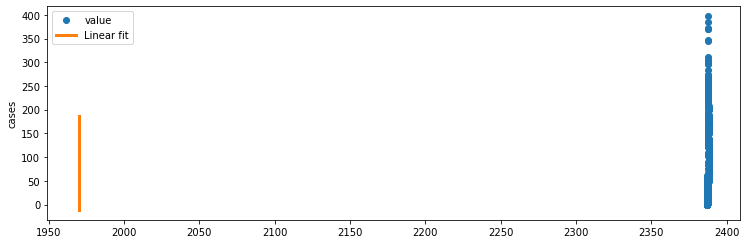

In [28]:
import scipy.stats as sp

df2 = pd.read_csv('challenge-data/truth/2021-05-16_LK_cases.csv')

y=np.array(df2[df2.location==11001]['value'].dropna().values, dtype=float)
x=np.array(df2[df2.location==11001]['target'].dropna().index.values, dtype=float)
slope, intercept, r_value, p_value, std_err =sp.linregress(x,y)
xf = np.linspace(min(x),max(x),100)
xf1 = xf.copy()
xf1 = pd.to_datetime(xf1)
yf = (slope*xf)+intercept
print('r = ', r_value, '\n', 'p = ', p_value, '\n', 's = ', std_err)
f, ax = plt.subplots(1, 1)
df2[df2.location==11001]['value'].dropna().plot(ax=ax,marker='o', ls='')
ax.plot(xf1, yf,label='Linear fit', lw=3)

plt.ylabel('cases')
ax.legend();

# **3. RNN Implementation for the time series data**

In [3]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = MinMaxScaler()


In [167]:
df_train_BL_univ = pd.read_parquet(r'challenge-data/truth/2022-09-04_BL_cases.parquet')
df_train_BL_univ = df_train_BL_univ[df_train_BL_univ.location==11]
df_train_BL_univ.rename(columns = {'target':'day'}, inplace=True)


df_test_BL_univ = pd.read_csv('challenge-data/evaluation/2022-10-02_BL_cases.csv', parse_dates=True)
df_test_BL_univ = df_test_BL_univ[df_test_BL_univ.location==11]
df_test_BL_univ = df_test_BL_univ.tail(28).reset_index()
df_test_BL_univ.rename(columns = {'target':'day'}, inplace=True)
df_test_BL_univ= df_test_BL_univ.drop(['index'], axis=1)
df_test_BL_univ

,location,day,value
0,11,2022-09-03,212.358437
1,11,2022-09-04,212.440313
2,11,2022-09-05,218.499119
3,11,2022-09-06,204.198152
4,11,2022-09-07,206.081295
5,11,2022-09-08,205.426289
6,11,2022-09-09,202.478761
7,11,2022-09-10,202.888140
8,11,2022-09-11,202.806264
9,11,2022-09-12,212.931567


<AxesSubplot:xlabel='day'>

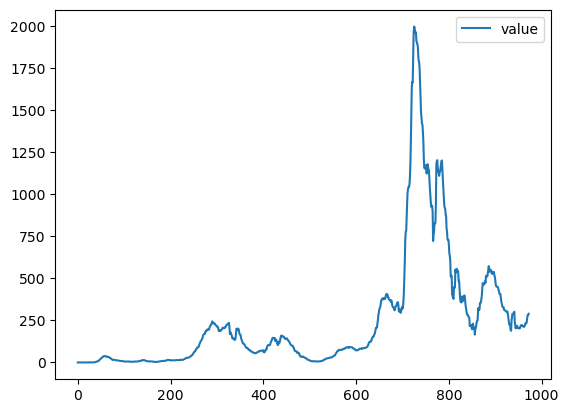

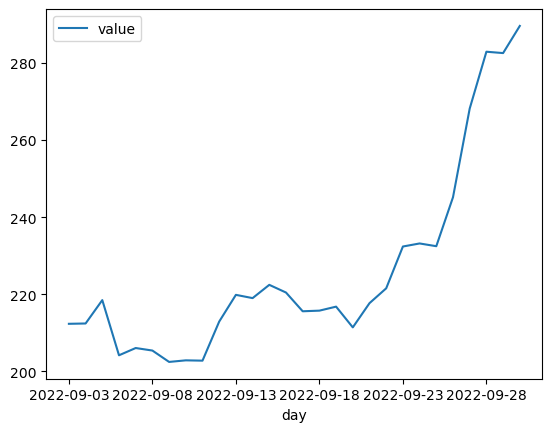

In [171]:
df_appended = pd.concat([df_train_BL_univ, df_test_BL_univ], ignore_index=True)
#df_appended = df_appended.drop(['location'], axis=1)
#df_appended = df_appended.set_index('day')

df_appended.plot()
df_test_BL_univ.plot()

In [169]:
df_train_BL_univ = df_train_BL_univ.set_index('day').drop(['location'], axis=1)
df_test_BL_univ = df_test_BL_univ.set_index('day').drop(['location'], axis=1)
df_test_BL_univ

,value
day,
2022-09-03,212.358437
2022-09-04,212.440313
2022-09-05,218.499119
2022-09-06,204.198152
2022-09-07,206.081295
2022-09-08,205.426289
2022-09-09,202.478761
2022-09-10,202.888140
2022-09-11,202.806264


**Scale the values between 0 and 1**

In [4]:
#df_train = df_train.drop('location')
def scale_data(train, test):
    scaler.fit(train)
    scaled_train=scaler.transform(train)
    scaled_test=scaler.transform(test)
    return scaled_train, scaled_test
#scaled_train_BL_univ[-10:]

**Prepare the RNN model**

In [381]:
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

def create_model(scaled_train, scaled_test, n_input, n_features):
    #n_input = 100
    #n_features = 1
    generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=64)
    #generator = TimeseriesGenerator(df_train, df_train, length=n_input, batch_size=1)

    model = Sequential()
    model.add(LSTM(75, activation='relu', input_shape=(n_input, n_features)))
    #model.add(Dropout(0.2))
    #model.add(LSTM(50, activation='relu', input_shape=(n_input, n_features)))
    #model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model, generator
#model.summary()
#generator[0]

**Fit the RNN model on the training data**

In [296]:
def training_phase(model, generator):
    
    model.fit(generator, epochs=20)
    loss_per_epoch = model.history.history['loss']
    #plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

**Plot loss per epoch from the training phase**

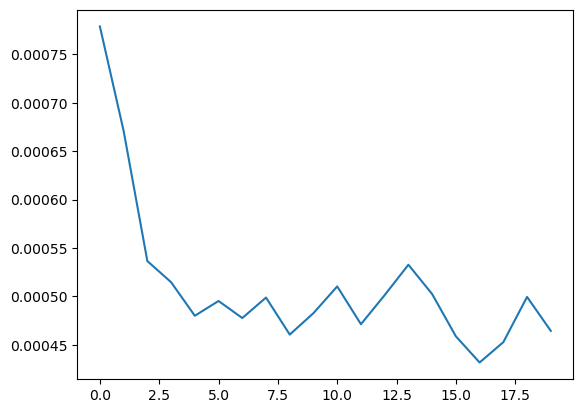

In [351]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

**Perform prediction for the test data**

In [305]:
def prediction_phase(model, scaled_train, test, n_input, n_features):    
    test_predictions = []

    first_eval_batch = scaled_train[-n_input:]
    current_batch = first_eval_batch.reshape((1, n_input, n_features))
    print(current_batch.shape)

    for i in range(len(test)):

        # get the prediction value for the first batch
        current_pred = model.predict(current_batch)[0]
        #print(current_pred)
        # append the prediction into the array
        test_predictions.append(current_pred) 

        # use the prediction to update the batch and remove the first value
        current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    return test_predictions

**Rescale the predicted values to get the actual true predictions and plot them with the test data**

In [8]:
def get_true_predictions(test_predictions, test):
    true_predictions = scaler.inverse_transform(test_predictions)
    return true_predictions
    #test['Predictions'] = true_predictions
    #test.value.plot()
    #test.Predictions.plot()
    #df_test.drop('location', axis=1)
    #plt.plot(df_test_BL_univ.target,df_test.value)
    #plt.plot(df_test.target,df_test.Predictions)
    #df_test.reset_index(inplace=True)
    #len(df_test)

In [445]:
df_train1 = df_train_BL.loc[df_train_BL.day < pd.Timestamp('2022-01-09')].reset_index().set_index('day').drop(['index','location'], axis=1)
df_test1 = df_test_BL.query("day>='2022-1-9' and day<='2022-2-5'").reset_index().set_index('day').drop(['index','location'], axis=1)
df_train1, df_test1

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


(                 value
 day                   
 2020-02-01    0.000000
 2020-02-02    0.000000
 2020-02-03    0.000000
 2020-02-04    0.000000
 2020-02-05    0.000000
 ...                ...
 2022-01-04  418.521608
 2022-01-05  501.461755
 2022-01-06  599.685379
 2022-01-07  733.142872
 2022-01-08  778.092666
 
 [708 rows x 1 columns],
                   value
 day                    
 2022-01-09   782.077286
 2022-01-10   871.376452
 2022-01-11   948.721756
 2022-01-12  1012.039012
 2022-01-13  1032.753580
 2022-01-14  1045.471615
 2022-01-15  1044.516398
 2022-01-16  1058.735489
 2022-01-17  1102.238811
 2022-01-18  1178.738065
 2022-01-19  1311.131174
 2022-01-20  1479.686077
 2022-01-21  1634.403977
 2022-01-22  1667.973040
 2022-01-23  1664.943637
 2022-01-24  1822.063226
 2022-01-25  1959.805551
 2022-01-26  1998.450911
 2022-01-27  1993.292738
 2022-01-28  1959.614507
 2022-01-29  1965.973525
 2022-01-30  1960.133054
 2022-01-31  1909.670292
 2022-02-01  1903.529610
 2022-02-02

In [382]:
dates = [
        #('2022-01-09', '2022-1-9', '2022-2-5'),
         #('2022-01-16', '2022-1-16', '2022-2-12'),
         #('2022-01-23', '2022-1-23', '2022-2-19'),
         #('2022-01-30', '2022-1-30', '2022-2-26'),
         ('2022-04-10', '2022-4-10', '2022-5-7'),
         ('2022-04-17', '2022-4-17', '2022-5-14'),
         ('2022-04-24', '2022-4-24', '2022-5-21'),
         ('2022-05-01', '2022-5-1', '2022-5-28'),
         ('2022-07-10', '2022-7-10', '2022-8-6'),
         ('2022-07-17', '2022-7-17', '2022-8-13'),
         ('2022-07-24', '2022-7-24', '2022-8-20'),
         ('2022-07-31', '2022-7-31', '2022-8-27')]
         #('2022-09-04', '2022-9-4', '2022-10-02')]
datasets = []
datasets1 = []

#print(df_cx)

for i, date in enumerate(dates):
    df_train = df_train_BL.loc[df_train_BL.day < pd.Timestamp(date[0])].reset_index().set_index('day').drop(['index','location'], axis=1)
    df_test = df_test_BL.query("day >= @date[1] and day <= @date[2]").reset_index().set_index('day').drop(['index','location'], axis=1)
    datasets1.append((df_train, df_test))
    
for i, date in enumerate(dates):
    df_train = df_train_BL.loc[df_train_BL.day < pd.Timestamp(date[0])].reset_index().set_index('day').drop(['index','location'], axis=1)
    df_test = df_test_BL.query("day >= @date[1] and day <= @date[2]").reset_index().set_index('day').drop(['index','location'], axis=1)
    df_cx_train = df_cx[df_cx.day < pd.Timestamp(date[0])].reset_index().set_index('day').drop(['index'], axis=1)
    df_cx_test = df_cx[df_cx.day.between(pd.Timestamp(date[1]), pd.Timestamp(date[2]))].reset_index().set_index('day').drop(['index'], axis=1)
    
    df_train['cx'] = df_cx_train.cx
    df_test['cx'] = df_cx_test.cx
    df_train['<k>'] = df_cx_train['<k>']
    df_test['<k>'] = df_cx_test['<k>']
    datasets.append((df_train, df_test))
    print()

# len(datasets)
    
# df_train1 = df_train_BL.loc[df_train_BL.day < pd.Timestamp('2022-01-09')].reset_index().set_index('day').drop(['index','location'], axis=1)
# df_test1 = df_test_BL.query("day>='2022-1-9' and day<='2022-2-5'").reset_index().set_index('day').drop(['index','location'], axis=1)

# df_train2 = df_train_BL.loc[df_train_BL.day < pd.Timestamp('2022-01-16')].reset_index().set_index('day').drop(['index','location'], axis=1)
# df_test2 = df_test_BL.query("day>='2022-1-16' and day<='2022-2-12'").reset_index().set_index('day').drop(['index','location'], axis=1)

# datasets = [(df_train1, df_test1), (df_train2, df_test2)]

c=0
for dataset in tqdm(datasets1):
    
    scaled_train, scaled_test = scale_data(dataset[0], dataset[1])
    #print(scaled_train.shape)
    model, generator = create_model(scaled_train, scaled_test, 60, 1)
    training_phase(model, generator)
    test_predictions = prediction_phase(model, scaled_train, dataset[1], n_input=60, n_features=1)
    true_predictions = get_true_predictions(test_predictions, dataset[1])
    #print(true_predictions[:,1])
    dataset[1]['Predictions'] = true_predictions[:,0]
    c=c+1
    #plt.plot(dataset[1].value)
    #plt.plot(dataset[1].Predictions)
    #dataset[1].Predictions.plot()
    

# #     #print(dataset[1])
# # #df_test1

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 1/20
12/12 [==============================] - 1s 20ms/step - loss: 0.0479
Epoch 2/20
12/12 [==============================] - 0s 20ms/step - loss: 0.0344
Epoch 3/20
12/12 [==============================] - 0s 19ms/step - loss: 0.0213
Epoch 4/20
12/12 [==============================] - 0s 19ms/step - loss: 0.0085
Epoch 5/20
12/12 [==============================] - 0s 18ms/step - loss: 0.0047
Epoch 6/20
12/12 [==============================] - 0s 18ms/step - loss: 0.0033
Epoch 7/20
12/12 [==============================] - 0s 18ms/step - loss: 0.0024
Epoch 8/20
12/12 [==============================] - 0s 18ms/step - loss: 0.0021
Epoch 9/20
12/12 [==============================] - 0s 18ms/step - loss: 0.0019
Epoch 10/20
12/12 [==============================] - 0s 18ms/step - loss: 0.0016
Epoch 11/20
12/12 [==============================] - 0s 18ms/step - loss: 0.0013
Epoch 12/20
12/12 [==============================] - 0s 18ms/step - loss: 0.0012
Epoch 13/20
12/12 [==================

 12%|█▎        | 1/8 [00:10<01:11, 10.21s/it]

Epoch 1/20
12/12 [==============================] - 1s 18ms/step - loss: 0.0389
Epoch 2/20
12/12 [==============================] - 0s 19ms/step - loss: 0.0185
Epoch 3/20
12/12 [==============================] - 0s 19ms/step - loss: 0.0064
Epoch 4/20
12/12 [==============================] - 0s 18ms/step - loss: 0.0037
Epoch 5/20
12/12 [==============================] - 0s 18ms/step - loss: 0.0023
Epoch 6/20
12/12 [==============================] - 0s 18ms/step - loss: 0.0024
Epoch 7/20
12/12 [==============================] - 0s 18ms/step - loss: 0.0022
Epoch 8/20
12/12 [==============================] - 0s 18ms/step - loss: 0.0019
Epoch 9/20
12/12 [==============================] - 0s 18ms/step - loss: 0.0016
Epoch 10/20
12/12 [==============================] - 0s 18ms/step - loss: 0.0014
Epoch 11/20
12/12 [==============================] - 0s 18ms/step - loss: 0.0013
Epoch 12/20
12/12 [==============================] - 0s 18ms/step - loss: 0.0012
Epoch 13/20
12/12 [==================

 25%|██▌       | 2/8 [00:20<01:01, 10.21s/it]

Epoch 1/20
12/12 [==============================] - 1s 18ms/step - loss: 0.0490
Epoch 2/20
12/12 [==============================] - 0s 18ms/step - loss: 0.0323
Epoch 3/20
12/12 [==============================] - 0s 18ms/step - loss: 0.0169
Epoch 4/20
12/12 [==============================] - 0s 18ms/step - loss: 0.0082
Epoch 5/20
12/12 [==============================] - 0s 18ms/step - loss: 0.0036
Epoch 6/20
12/12 [==============================] - 0s 18ms/step - loss: 0.0043
Epoch 7/20
12/12 [==============================] - 0s 18ms/step - loss: 0.0069
Epoch 8/20
12/12 [==============================] - 0s 18ms/step - loss: 0.0038
Epoch 9/20
12/12 [==============================] - 0s 18ms/step - loss: 0.0027
Epoch 10/20
12/12 [==============================] - 0s 18ms/step - loss: 0.0020
Epoch 11/20
12/12 [==============================] - 0s 18ms/step - loss: 0.0019
Epoch 12/20
12/12 [==============================] - 0s 18ms/step - loss: 0.0017
Epoch 13/20
12/12 [==================

 38%|███▊      | 3/8 [00:30<00:50, 10.15s/it]

Epoch 1/20
12/12 [==============================] - 1s 20ms/step - loss: 0.0300
Epoch 2/20
12/12 [==============================] - 0s 19ms/step - loss: 0.0205
Epoch 3/20
12/12 [==============================] - 0s 19ms/step - loss: 0.0117
Epoch 4/20
12/12 [==============================] - 0s 19ms/step - loss: 0.0054
Epoch 5/20
12/12 [==============================] - 0s 18ms/step - loss: 0.0053
Epoch 6/20
12/12 [==============================] - 0s 18ms/step - loss: 0.0049
Epoch 7/20
12/12 [==============================] - 0s 18ms/step - loss: 0.0045
Epoch 8/20
12/12 [==============================] - 0s 18ms/step - loss: 0.0032
Epoch 9/20
12/12 [==============================] - 0s 18ms/step - loss: 0.0026
Epoch 10/20
12/12 [==============================] - 0s 18ms/step - loss: 0.0025
Epoch 11/20
12/12 [==============================] - 0s 18ms/step - loss: 0.0025
Epoch 12/20
12/12 [==============================] - 0s 18ms/step - loss: 0.0023
Epoch 13/20
12/12 [==================

 50%|█████     | 4/8 [00:40<00:41, 10.26s/it]

Epoch 1/20
13/13 [==============================] - 3s 24ms/step - loss: 0.0373
Epoch 2/20
13/13 [==============================] - 0s 25ms/step - loss: 0.0244
Epoch 3/20
13/13 [==============================] - 0s 24ms/step - loss: 0.0121
Epoch 4/20
13/13 [==============================] - 0s 24ms/step - loss: 0.0065
Epoch 5/20
13/13 [==============================] - 0s 24ms/step - loss: 0.0053
Epoch 6/20
13/13 [==============================] - 0s 24ms/step - loss: 0.0049
Epoch 7/20
13/13 [==============================] - 0s 24ms/step - loss: 0.0037
Epoch 8/20
13/13 [==============================] - 0s 24ms/step - loss: 0.0034
Epoch 9/20
13/13 [==============================] - 0s 25ms/step - loss: 0.0030
Epoch 10/20
13/13 [==============================] - 0s 25ms/step - loss: 0.0048
Epoch 11/20
13/13 [==============================] - 0s 24ms/step - loss: 0.0036
Epoch 12/20
13/13 [==============================] - 0s 24ms/step - loss: 0.0041
Epoch 13/20
13/13 [==================

 62%|██████▎   | 5/8 [00:54<00:34, 11.58s/it]

Epoch 1/20
14/14 [==============================] - 1s 22ms/step - loss: 0.0466
Epoch 2/20
14/14 [==============================] - 0s 22ms/step - loss: 0.0233
Epoch 3/20
14/14 [==============================] - 0s 22ms/step - loss: 0.0162
Epoch 4/20
14/14 [==============================] - 0s 23ms/step - loss: 0.0088
Epoch 5/20
14/14 [==============================] - 0s 24ms/step - loss: 0.0151
Epoch 6/20
14/14 [==============================] - 0s 24ms/step - loss: 0.0102
Epoch 7/20
14/14 [==============================] - 0s 21ms/step - loss: 0.0068
Epoch 8/20
14/14 [==============================] - 0s 21ms/step - loss: 0.0047
Epoch 9/20
14/14 [==============================] - 0s 22ms/step - loss: 0.0035
Epoch 10/20
14/14 [==============================] - 0s 22ms/step - loss: 0.0025
Epoch 11/20
14/14 [==============================] - 0s 21ms/step - loss: 0.0023
Epoch 12/20
14/14 [==============================] - 0s 22ms/step - loss: 0.0022
Epoch 13/20
14/14 [==================

 75%|███████▌  | 6/8 [01:07<00:23, 11.80s/it]

Epoch 1/20
14/14 [==============================] - 1s 21ms/step - loss: 0.0307
Epoch 2/20
14/14 [==============================] - 0s 23ms/step - loss: 0.0138
Epoch 3/20
14/14 [==============================] - 0s 23ms/step - loss: 0.0093
Epoch 4/20
14/14 [==============================] - 0s 21ms/step - loss: 0.0049
Epoch 5/20
14/14 [==============================] - 0s 21ms/step - loss: 0.0218
Epoch 6/20
14/14 [==============================] - 0s 21ms/step - loss: 0.0138
Epoch 7/20
14/14 [==============================] - 0s 22ms/step - loss: 0.0076
Epoch 8/20
14/14 [==============================] - 0s 21ms/step - loss: 0.0068
Epoch 9/20
14/14 [==============================] - 0s 21ms/step - loss: 0.0048
Epoch 10/20
14/14 [==============================] - 0s 20ms/step - loss: 0.0036
Epoch 11/20
14/14 [==============================] - 0s 21ms/step - loss: 0.0028
Epoch 12/20
14/14 [==============================] - 0s 20ms/step - loss: 0.0026
Epoch 13/20
14/14 [==================

 88%|████████▊ | 7/8 [01:19<00:11, 11.84s/it]

Epoch 1/20
14/14 [==============================] - 1s 21ms/step - loss: 0.0312
Epoch 2/20
14/14 [==============================] - 0s 21ms/step - loss: 0.0177
Epoch 3/20
14/14 [==============================] - 0s 21ms/step - loss: 0.0083
Epoch 4/20
14/14 [==============================] - 0s 20ms/step - loss: 0.0049
Epoch 5/20
14/14 [==============================] - 0s 21ms/step - loss: 0.0031
Epoch 6/20
14/14 [==============================] - 0s 21ms/step - loss: 0.0025
Epoch 7/20
14/14 [==============================] - 0s 21ms/step - loss: 0.0025
Epoch 8/20
14/14 [==============================] - 0s 22ms/step - loss: 0.0018
Epoch 9/20
14/14 [==============================] - 0s 20ms/step - loss: 0.0018
Epoch 10/20
14/14 [==============================] - 0s 21ms/step - loss: 0.0016
Epoch 11/20
14/14 [==============================] - 0s 21ms/step - loss: 0.0013
Epoch 12/20
14/14 [==============================] - 0s 21ms/step - loss: 0.0017
Epoch 13/20
14/14 [==================

100%|██████████| 8/8 [01:30<00:00, 11.33s/it]


In [357]:
datasets[0][1]

,value,cx,<k>
day,,,
2022-04-10,729.594922,193.52458,22.469105
2022-04-11,698.564008,184.25592,24.760760
2022-04-12,647.009570,287.36835,24.451313
2022-04-13,635.219460,158.26580,24.749996
2022-04-14,601.513937,224.58063,31.141747
2022-04-15,510.877468,135.06525,23.188929
2022-04-16,515.517095,145.01118,28.679830
2022-04-17,515.544386,177.87704,25.437680
2022-04-18,404.466268,243.20401,28.323402


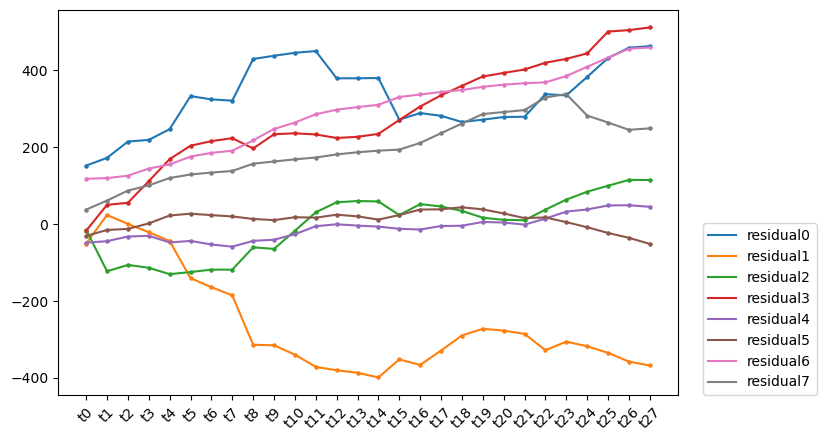

In [376]:
dfs_test = [dataset[1] for dataset in datasets if len(dataset)>1]
idx = ['t'+str(i)for i in range(28)]
df_residual = pd.DataFrame()
#print(df_residual)
fig = plt.figure(figsize=(8,5))
for i, df_test in enumerate(dfs_test):
    #print(i, len(df_test))
    df_test=df_test.reset_index(drop=True)
    #df_test['Residual'] = abs(df_test['Predictions']-df_test['value'])
    #print(df_test)
    df_test['residual'] = df_test['Predictions']-df_test['value']
    col_name = 'residual' + str(i)
    new_col = pd.Series(df_test.residual.tolist(), name=col_name)
    #df_residual['residual'+str(dfs_test.index(df_test))] = df_test.residual
    df_test['idx'] = idx
    df_residual = pd.concat([df_residual, new_col], axis=1)
    df_residual['idx'] = idx
    #df_residual.reset_index(drop=True)
    #df_test.plot(kind='scatter', x='idx', y='Residual', s=5)
    
    plt.scatter(x=df_test.idx, y=df_test.residual, s=5)
    plt.plot(df_test.idx, df_test.residual, label=col_name)
    #plt.violinplot(df_test.residual)
    #plt.boxplot(df_test)
    plt.legend(loc=(1.04, 0))
    plt.xticks(rotation=45)
    #print(df_test)
    

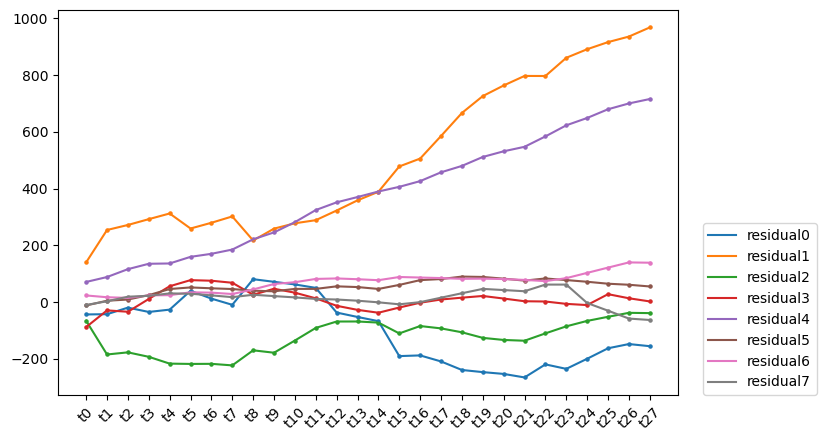

In [386]:
dfs_test = [dataset[1] for dataset in datasets1 if len(dataset)>1]
idx = ['t'+str(i)for i in range(28)]
df_residual1 = pd.DataFrame()
#print(df_residual)
fig = plt.figure(figsize=(8,5))
for i, df_test in enumerate(dfs_test):
    #print(i, len(df_test))
    df_test=df_test.reset_index(drop=True)
    #df_test['Residual'] = abs(df_test['Predictions']-df_test['value'])
    #print(df_test)
    df_test['residual'] = df_test['Predictions']-df_test['value']
    col_name = 'residual' + str(i)
    new_col = pd.Series(df_test.residual.tolist(), name=col_name)
    #df_residual['residual'+str(dfs_test.index(df_test))] = df_test.residual
    df_test['idx'] = idx
    df_residual1 = pd.concat([df_residual1, new_col], axis=1)
    df_residual1['idx'] = idx
    #df_residual.reset_index(drop=True)
    #df_test.plot(kind='scatter', x='idx', y='Residual', s=5)
    plt.scatter(x=df_test.idx, y=df_test.residual, s=5)
    plt.plot(df_test.idx, df_test.residual, label=col_name)
    #plt.violinplot(df_test.residual)
    #plt.boxplot(df_test)
    plt.legend(loc=(1.04, 0))
    plt.xticks(rotation=45)
    #print(df_test)

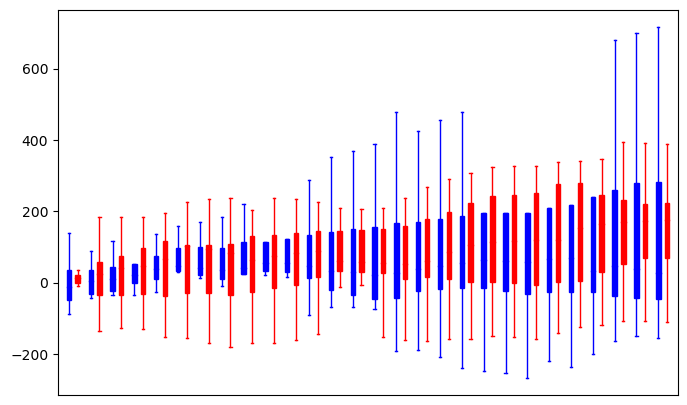

In [403]:
import seaborn as sns
#print(df_residual)
#df_residual1=df_residual1.drop(['idx'], axis=1)
fig = plt.figure(figsize=(8,5))
#df_residual1['idx'] = idx
df_residual1=df_residual1.reset_index(drop=True)
df_residualtrans1 = df_residual1.transpose()
#sns.violinplot(data=df_residual)
#print(df_residualtrans1)
plt.xticks(rotation=45)

boxplot1=plt.boxplot(df_residualtrans1,patch_artist=True, showfliers=False, 
                           positions=np.arange(df_residualtrans1.shape[1]), widths=0.2)
boxplot=plt.boxplot(df_residualtrans, patch_artist=True, showfliers=False, 
                           positions=np.arange(df_residualtrans.shape[1])+.4, widths=0.2)
for _, line_list in boxplot1.items():
    for line in line_list:
        line.set_color('blue')
for _, line_list in boxplot.items():
    for line in line_list:
        line.set_color('red')
#plt.boxplot(df_residual)
plt.tick_params(axis='x',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
#plt.xticks(np.arange(28), rotation=45)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


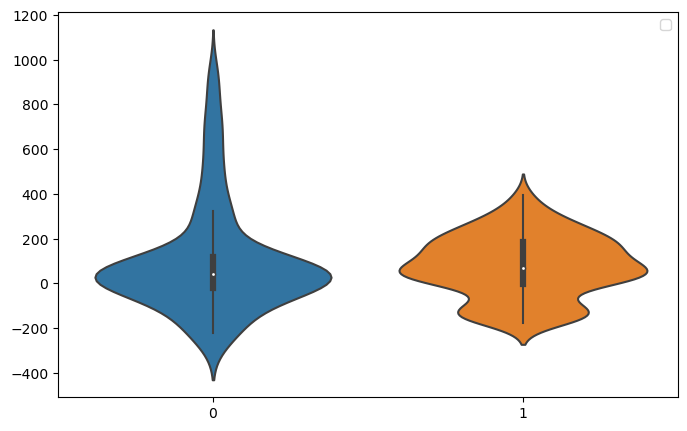

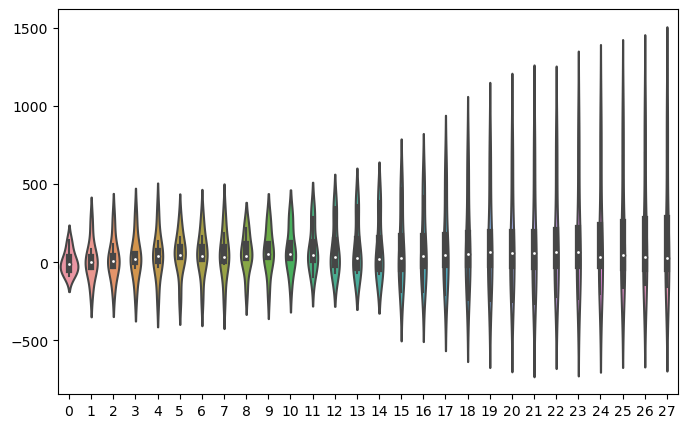

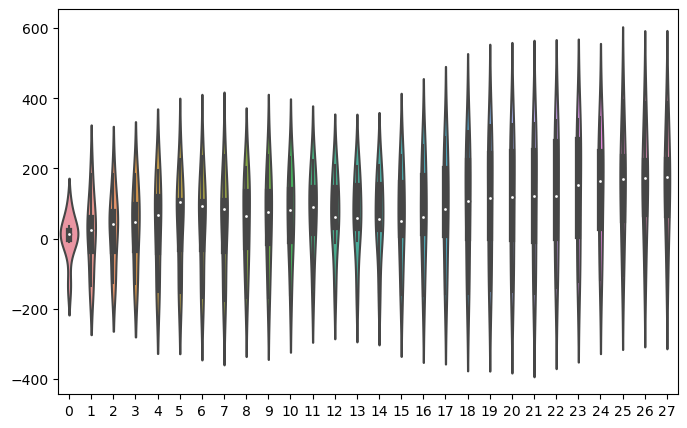

In [430]:
fig = plt.figure(figsize=(8,5))
sns.violinplot(data=[df_residualtrans1, df_residualtrans], labels=['univariate', 'multivariate'])
plt.legend()
plt.show()
fig = plt.figure(figsize=(8,5))
sns.violinplot(data=df_residualtrans1)
plt.show()
fig = plt.figure(figsize=(8,5))
sns.violinplot(data=df_residualtrans)
plt.show()

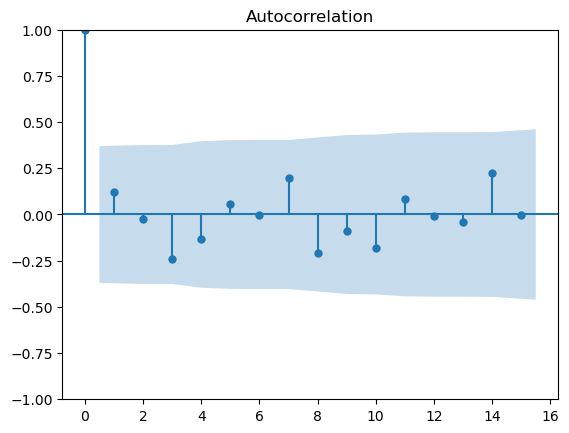

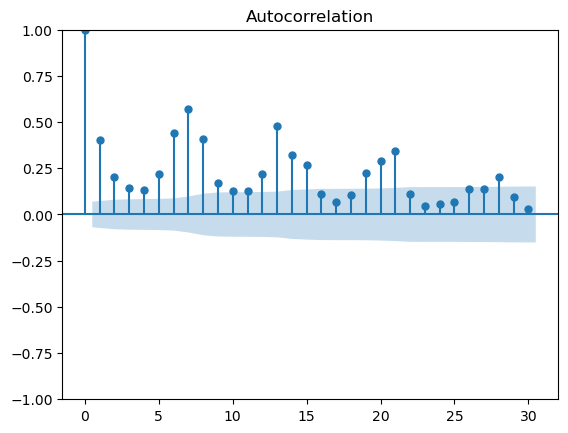

In [422]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot, quarter_plot
for dataset in datasets:
    plot_acf(dataset[1].cx)
    plot_acf(dataset[0].cx)
    #month_plot(dataset[1].value)
    #plot_pacf(dataset[1].value)
    break

**Calculate the root mean squared error**

In [149]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse=[sqrt(mean_squared_error(df_test['value'],df_test['Predictions'])) for df_test in dfs_test]
print(rmse)

[4478.779679657708, 110.15354465740849, 212.78211673074412, 116.37522258761103, 302.70326532878056, 253.12955050289008, 184.38437244510106, 153.00943257040413, 250.9947739762199]


In [80]:
df_test=df_test.drop(['sample_id'], axis=1)

In [54]:
df_test['location'] = 16077

In [126]:
temp_df = df_test.copy()
#df_test = df_test.append(temp_df)
#new.sample_id=0
dfs = []
for i in range(100):
    new = temp_df.copy()
    new.sample_id = i
    dfs.append(new)
    #df_test['sample_id'] = i
    
  
res = pd.concat(dfs, ignore_index=True)
res= res[['location', 'target', 'sample_id', 'value']]
len(res), res.head(), res.tail()

(2800,
    location     target  sample_id       value
 0     16077 2022-09-03          0  168.043753
 1     16077 2022-09-04          0  161.233910
 2     16077 2022-09-05          0  152.233066
 3     16077 2022-09-06          0  147.656340
 4     16077 2022-09-07          0  142.482621,
       location     target  sample_id       value
 2795     16077 2022-09-26         99  139.177177
 2796     16077 2022-09-27         99  139.423758
 2797     16077 2022-09-28         99  139.668240
 2798     16077 2022-09-29         99  139.940275
 2799     16077 2022-09-30         99  140.246109)

In [127]:
res.to_parquet('2022-09-04_model_LK_cases.parquet')

In [13]:
df_par = pd.read_parquet('submissions/NetCheck/2022-09-04_model_LK_cases.parquet')
df_par.head(), df_par.tail()

(   location     target  sample_id       value
 0     16077 2022-09-03          0  168.043753
 1     16077 2022-09-04          0  161.233910
 2     16077 2022-09-05          0  152.233066
 3     16077 2022-09-06          0  147.656340
 4     16077 2022-09-07          0  142.482621,
       location     target  sample_id       value
 2795     16077 2022-09-26         99  139.177177
 2796     16077 2022-09-27         99  139.423758
 2797     16077 2022-09-28         99  139.668240
 2798     16077 2022-09-29         99  139.940275
 2799     16077 2022-09-30         99  140.246109)

# Get Data from covid_results_v5 and covid_network_v5_topology tables from database

In [249]:
db_usr, db_pwd = 'nishant_niram', 'jsadrelk3Fsh3Dsw'
conn = psycopg2.connect('host=ex03.ionos.netcheck.de port=5432 dbname=x4intern_covid user='+db_usr+' password='+db_pwd)
cur = conn.cursor()

**Get Topology data**

In [45]:
query = """
    select * from covid_network_v5_topology_python
    --where crv.location like 'Berlin' 
    where day between '2020-02-01' and '2022-09-02'; 
"""
cur.execute(query)
df_topology = pd.DataFrame(cur.fetchall(), columns=['day', 
                                                    'aggregation_window',
                                                    'number_nodes', 
                                                    'number_edges', 
                                                    'number_connected_components',
                                                    'size_largest_connected_component',
                                                    'graph_clique_number',
                                                    'wiener_index',
                                                    'transitivity',
                                                    'average_clustering',
                                                    'degree_assortativity_coefficient',
                                                    'degree_pearson_correlation_coefficient',
                                                    'square_clustering_coefficient_mean',
                                                    'square_clustering_coefficient_max',
                                                    'degree_centrality_mean',
                                                    'degree_centrality_max',
                                                    'eigenvector_centrality_mean',
                                                    'eigenvector_centrality_max'])
#df_topology.head()
print(len(df_topology.columns))
df_topology=df_topology.drop(['aggregation_window', 'wiener_index', 'square_clustering_coefficient_max'], axis=1)
print(len(df_topology.columns))
print(len(df_topology))

18
15
945


In [22]:
df_topology.day.head(), df_topology.day.tail()

(0    2020-02-01
 1    2020-02-02
 2    2020-02-03
 3    2020-02-04
 4    2020-02-05
 Name: day, dtype: object,
 940    2022-08-29
 941    2022-08-30
 942    2022-08-31
 943    2022-09-01
 944    2022-09-02
 Name: day, dtype: object)

**Get training data**

In [265]:
query = """
    select day, "<k>", cx from covid_results_v5 crv 
    where crv.location like 'Berlin' 
    and crv.day between '2020-02-01' and '2022-08-27'
    order by day; 
"""
cur.execute(query)
# df2 = pd.DataFrame(cur.fetchall(), columns = ['day', 
#                                              'location',
#                                              'submitted_on',
#                                              'ktot_1',
#                                              'k2tot_1',
#                                              'ndid_1',
#                                              'npop_1',
#                                              'pdid_1',
#                                              'pping_1',
#                                              'plink_1',
#                                              'ktot_2',
#                                              'k2tot_2',
#                                              'ndid_2',
#                                              'npop_2',
#                                              'pdid_2',
#                                              'pping_2',
#                                              'plink_2',
#                                              'k2tot_12',
#                                              'stype_corrfac',
#                                              '<k>',
#                                              'CI(<k>)',
#                                              '<k^2>',
#                                              'CI(<k^2>)',
#                                              'cx',
#                                              'CI(cx)',
#                                              'cx_excl_stadiums',
#                                              'cx_only_stadiums'
# ])
df_cx = pd.DataFrame(cur.fetchall(), columns = ['day', 
                                             '<k>',
                                             'cx'
])

print(len(df_cx.columns), len(df_cx))
#df2.head(1), df2.tail(1)
df_cx.sort_values(by=['day'], ascending=True)
#df2.set_index('day')
df_cx

3 939


,day,<k>,cx
0,2020-02-01,44.540398,775.214660
1,2020-02-02,36.473755,355.874540
2,2020-02-03,30.178535,769.502750
3,2020-02-04,25.073523,79.406166
4,2020-02-05,25.168743,79.833680
...,...,...,...
934,2022-08-23,30.104576,169.266500
935,2022-08-24,32.176520,202.541800
936,2022-08-25,33.658990,192.621570
937,2022-08-26,35.470480,258.040900


In [50]:
#df_train.head(), df_topology.head(), 
df_train.tail(1), df_topology.tail(1), df2.tail(1)

(            location       value
 day                             
 2022-09-02   16077.0  182.217393,
             day  number_nodes  number_edges  number_connected_components  \
 944  2022-09-02        153047        127220                        40362   
 
      size_largest_connected_component  graph_clique_number  transitivity  \
 944                             51155                   17      0.212264   
 
      average_clustering  degree_assortativity_coefficient  \
 944            0.043978                          0.554996   
 
      degree_pearson_correlation_coefficient  \
 944                                0.554996   
 
      square_clustering_coefficient_mean  degree_centrality_mean  \
 944                             0.00845                0.000011   
 
      degree_centrality_max  eigenvector_centrality_mean  \
 944               0.000497                     0.000056   
 
      eigenvector_centrality_max  
 944                    0.201448  ,
             day        <k>   

number_nodes                             -0.025480
number_edges                              0.080077
number_connected_components              -0.172778
size_largest_connected_component          0.416583
graph_clique_number                       0.399742
transitivity                              0.179433
average_clustering                        0.098814
degree_assortativity_coefficient          0.333452
degree_pearson_correlation_coefficient    0.333452
square_clustering_coefficient_mean        0.097345
degree_centrality_mean                    0.182040
degree_centrality_max                     0.482844
eigenvector_centrality_mean               0.356274
eigenvector_centrality_max               -0.368342
location                                       NaN
value                                     0.131329
<k>                                       0.668355
cx                                        1.000000
dtype: float64

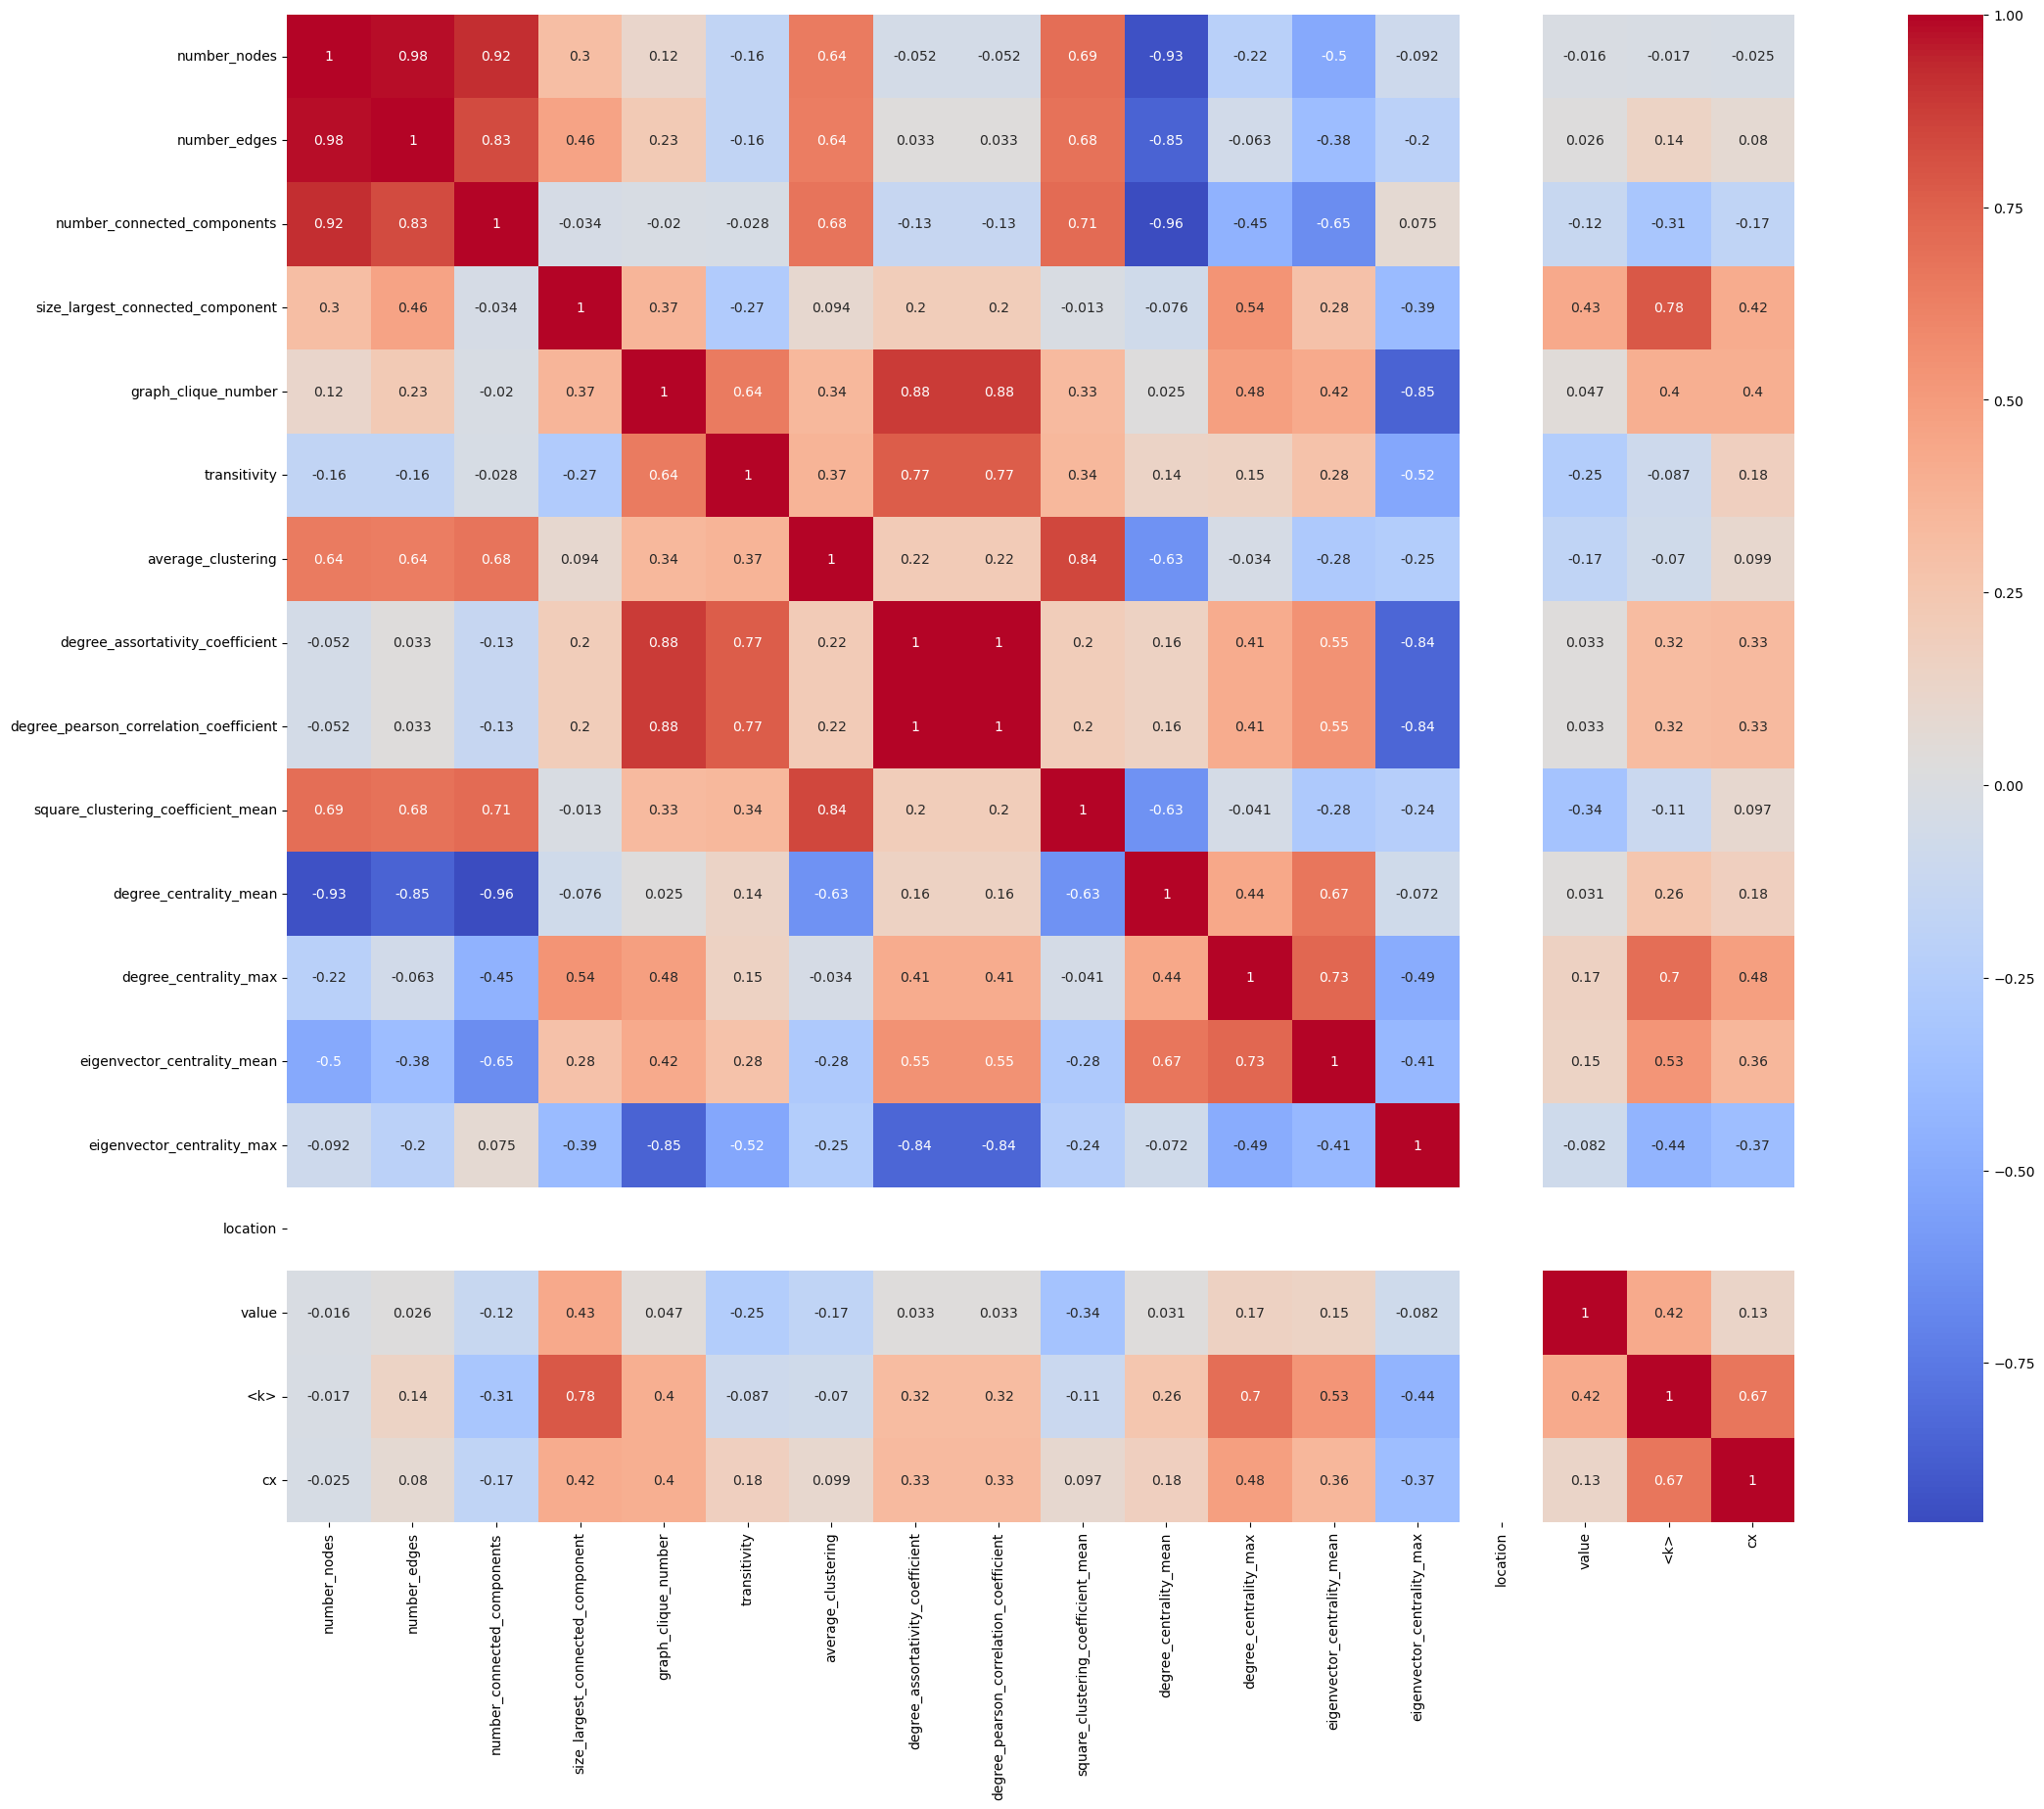

In [215]:
new_df = pd.merge(df_topology,df_train_BL, on=['day'])
new_df = pd.merge(new_df, df2, on=['day'])
mask = np.zeros_like(new_df.corr())
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(30, 20))
sns.heatmap(new_df.corr(), annot = True, fmt='.2g',cmap= 'coolwarm', square=True)

new_df = new_df.set_index('day')

new_df.corrwith(new_df.cx)


In [150]:
print(new_df.columns)

Index(['number_nodes', 'number_edges', 'number_connected_components',
       'size_largest_connected_component', 'graph_clique_number',
       'transitivity', 'average_clustering',
       'degree_assortativity_coefficient',
       'degree_pearson_correlation_coefficient',
       'square_clustering_coefficient_mean', 'degree_centrality_mean',
       'degree_centrality_max', 'eigenvector_centrality_mean',
       'eigenvector_centrality_max', 'location', 'value', '<k>', 'cx'],
      dtype='object')


Epoch 1/50
14/14 [==============================] - 1s 28ms/step - loss: 0.0569
Epoch 2/50
14/14 [==============================] - 0s 28ms/step - loss: 0.0245
Epoch 3/50
14/14 [==============================] - 0s 28ms/step - loss: 0.0193
Epoch 4/50
14/14 [==============================] - 0s 28ms/step - loss: 0.0145
Epoch 5/50
14/14 [==============================] - 0s 29ms/step - loss: 0.0121
Epoch 6/50
14/14 [==============================] - 0s 29ms/step - loss: 0.0112
Epoch 7/50
14/14 [==============================] - 0s 29ms/step - loss: 0.0102
Epoch 8/50
14/14 [==============================] - 0s 28ms/step - loss: 0.0084
Epoch 9/50
14/14 [==============================] - 0s 28ms/step - loss: 0.0071
Epoch 10/50
14/14 [==============================] - 0s 28ms/step - loss: 0.0064
Epoch 11/50
14/14 [==============================] - 0s 28ms/step - loss: 0.0060
Epoch 12/50
14/14 [==============================] - 0s 28ms/step - loss: 0.0059
Epoch 13/50
14/14 [==================

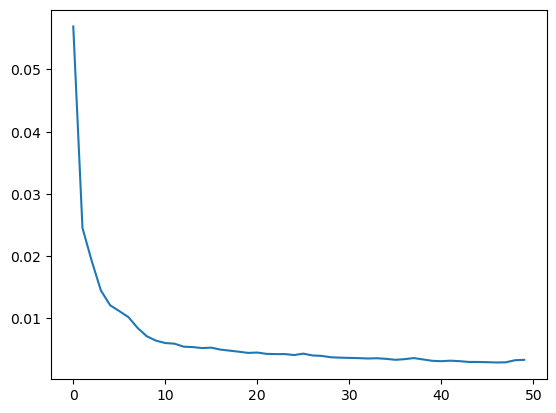

In [210]:
scaler.fit(new_df)
scaled_train=scaler.transform(new_df)
#scaled_test=scaler.transform(df_test)

from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM

n_input = 60
n_features = 18
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=64)
#generator = TimeseriesGenerator(df_train, df_train, length=n_input, batch_size=1)

model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(18))
model.compile(optimizer='adam', loss='mse')
#model.summary()
#generator[0]
model.fit(generator, epochs=50)
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [211]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 100)               47600     
                                                                 
 dense_6 (Dense)             (None, 18)                1818      
                                                                 
Total params: 49,418
Trainable params: 49,418
Non-trainable params: 0
_________________________________________________________________


**Get test data**

In [119]:
query1 = """
    select day, "<k>", cx from covid_results_v5 crv 
    where crv.location like 'Berlin' 
    and crv.day between '2022-09-03' and '2022-09-30';
"""
cur.execute(query1)
df_cx_test = pd.DataFrame(cur.fetchall(), columns = ['day', 
                                             '<k>',
                                             'cx'
])

print(len(df_cx_test.columns), len(df_cx_test))
#df_cx_test.head(5)

query2 = """
    select * from covid_network_v5_topology_python
    --where crv.location like 'Berlin' 
    where day between '2022-09-03' and '2022-09-30'; 
"""
cur.execute(query2)
df_topology_test = pd.DataFrame(cur.fetchall(), columns=['day', 
                                                    'aggregation_window',
                                                    'number_nodes', 
                                                    'number_edges', 
                                                    'number_connected_components',
                                                    'size_largest_connected_component',
                                                    'graph_clique_number',
                                                    'wiener_index',
                                                    'transitivity',
                                                    'average_clustering',
                                                    'degree_assortativity_coefficient',
                                                    'degree_pearson_correlation_coefficient',
                                                    'square_clustering_coefficient_mean',
                                                    'square_clustering_coefficient_max',
                                                    'degree_centrality_mean',
                                                    'degree_centrality_max',
                                                    'eigenvector_centrality_mean',
                                                    'eigenvector_centrality_max'])
#df_topology.head()
print(len(df_topology_test.columns))
df_topology_test=df_topology_test.drop(['aggregation_window', 'wiener_index', 'square_clustering_coefficient_max'], axis=1)
print(len(df_topology_test.columns))
print(df_topology_test)


3 28
18
15
           day  number_nodes  number_edges  number_connected_components  \
0   2022-09-03        147660        121301                        39572   
1   2022-09-04        143629        115382                        39478   
2   2022-09-05        141011        112761                        39097   
3   2022-09-06        140508        112999                        38867   
4   2022-09-07        140846        113564                        38912   
5   2022-09-08        140483        112211                        38852   
6   2022-09-09        140184        111604                        38660   
7   2022-09-10        140643        113020                        38638   
8   2022-09-11        140387        113079                        38583   
9   2022-09-12        138675        111928                        38488   
10  2022-09-13        138116        111073                        38290   
11  2022-09-14        137085        109644                        38208   
12  2022-09-15

In [192]:
#df_topology_test.day, df_test.day, df_cx_test.day
new_df_test = pd.merge(df_topology_test, df_cx_test, on=['day'])
#new_df_test = new_df_test.set_index('day').join(df_test.set_index('day'))
new_df_test['value'] = df_test_BL.value
new_df_test['location'] = df_test_BL.location
#df_test = df_test.reset_index()
#df_test = df_test.drop(['level_0', 'index'], axis=1)
#new_df_test = pd.merge(new_df_test, df_test, on=['day'])
new_df_test = new_df_test.set_index('day')
new_df_test = new_df_test[['number_nodes', 'number_edges', 'number_connected_components',
       'size_largest_connected_component', 'graph_clique_number',
       'transitivity', 'average_clustering',
       'degree_assortativity_coefficient',
       'degree_pearson_correlation_coefficient',
       'square_clustering_coefficient_mean', 'degree_centrality_mean',
       'degree_centrality_max', 'eigenvector_centrality_mean',
       'eigenvector_centrality_max', 'location', 'value', '<k>', 'cx']]
new_df_test.head()

,number_nodes,number_edges,number_connected_components,size_largest_connected_component,graph_clique_number,transitivity,average_clustering,degree_assortativity_coefficient,degree_pearson_correlation_coefficient,square_clustering_coefficient_mean,degree_centrality_mean,degree_centrality_max,eigenvector_centrality_mean,eigenvector_centrality_max,location,value,<k>,cx
day,,,,,,,,,,,,,,,,,,
2022-09-03,147660,121301,39572,47807,17,0.217752,0.043599,0.583535,0.583535,0.008687,0.000011,0.000481,0.000057,0.200997,11,212.358437,51.335724,1076.84890
2022-09-04,143629,115382,39478,43230,17,0.213133,0.042161,0.592078,0.592078,0.008576,0.000011,0.000480,0.000060,0.200680,11,212.440313,37.906560,359.55484
2022-09-05,141011,112761,39097,42330,17,0.212449,0.041391,0.594139,0.594139,0.008378,0.000011,0.000489,0.000061,0.200597,11,218.499119,34.805454,248.18503
2022-09-06,140508,112999,38867,42324,17,0.220955,0.042007,0.602509,0.602509,0.008377,0.000011,0.000491,0.000061,0.200590,11,204.198152,34.681170,221.34328
2022-09-07,140846,113564,38912,42300,17,0.225262,0.042630,0.600644,0.600644,0.008382,0.000011,0.000490,0.000061,0.200606,11,206.081295,35.943676,220.90349


In [193]:
last_train_batch = scaled_train[-60:]
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

model.predict(last_train_batch)
print(scaled_test[0])

1/1 [==============================] - 0s 149ms/step
[0.22813129 0.31777279 0.05421405 0.63204976 0.52173913 0.34692967
 0.38859925 0.62834974 0.62834974 0.21781387 0.68704979 0.44149798
 0.52472662 0.06076795 0.         0.07205826 1.17262377 0.59492238]


In [212]:
test_predictions = []
scaled_test=scaler.transform(new_df_test)
first_eval_batch = scaled_train[-n_input:]
print(first_eval_batch.shape)
current_batch = first_eval_batch.reshape((1, n_input, n_features))
print(current_batch.shape)

for i in range(len(df_test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    print(current_pred)
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

(60, 18)
(1, 60, 18)
1/1 [==============================] - 0s 148ms/step
[0.30537754 0.4193662  0.23458289 0.8200146  0.44454277 0.23557802
 0.3775804  0.5157446  0.49113566 0.20673071 0.5316432  0.47707808
 0.45889965 0.05540066 0.03623693 0.11035288 0.6262385  0.1326254 ]
1/1 [==============================] - 0s 90ms/step
[0.30949157 0.42218903 0.23333953 0.8503347  0.43640321 0.22571893
 0.39142933 0.5144284  0.5033537  0.19224955 0.5207444  0.47805297
 0.4497732  0.05143793 0.03909618 0.10875226 0.63160163 0.13785455]
1/1 [==============================] - 0s 88ms/step
[0.3166837  0.42537794 0.23189335 0.88219285 0.4320326  0.21989597
 0.39677218 0.52162856 0.5118182  0.18642333 0.51042515 0.48414314
 0.44921523 0.05665151 0.03838778 0.11144688 0.63623023 0.14215486]
1/1 [==============================] - 0s 86ms/step
[0.32415462 0.43009797 0.23085426 0.9132583  0.4255618  0.21032943
 0.40041244 0.5223157  0.51214117 0.17966323 0.5006075  0.49426663
 0.44909456 0.06479543 0.03714

257.89847187069654


<AxesSubplot:>

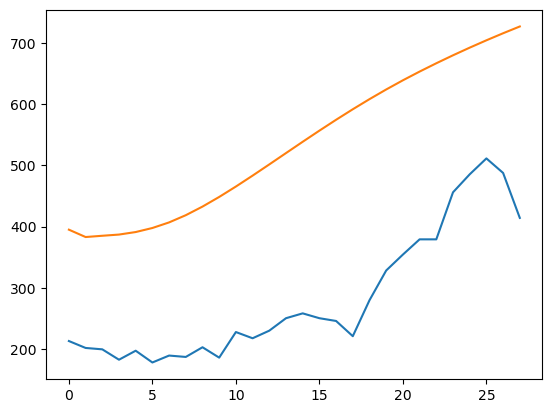

In [195]:
len(test_predictions)
true_predictions = scaler.inverse_transform(test_predictions)
true = [pred[15] for pred in true_predictions]
df_test['prediction'] = true
rmse=sqrt(mean_squared_error(df_test['value'],df_test['prediction']))
print(rmse)
df_test.value.plot()
df_test.prediction.plot()

In [213]:
true = [pred[15] for pred in true_predictions]
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(df_test['value'],true))
print(rmse)

257.89847187069654


In [207]:
vaccination_df = pd.read_excel('Impfquotenmonitoring.xlsx', 'Impfungen_proTag')
vaccination_df = vaccination_df[['Datum', 'Gesamtzahl verabreichter Impfstoffdosen']]
vaccination_df.drop(vaccination_df.tail(1).index,inplace=True)
vaccination_df['Datum'] = pd.to_datetime(vaccination_df['Datum'], format='%d.%m.%Y')
vaccination_df = vaccination_df[vaccination_df.Datum<datetime(2022, 9, 3)]
vaccination_df.tail()

,Datum,Gesamtzahl verabreichter Impfstoffdosen
610,2022-08-29,16870
611,2022-08-30,33334
612,2022-08-31,36403
613,2022-09-01,32218
614,2022-09-02,27509


,location,day,value
388390,16077.0,2022-08-29,227.488795
388391,16077.0,2022-08-30,228.620580
388392,16077.0,2022-08-31,218.434515
388393,16077.0,2022-09-01,234.279506
388394,16077.0,2022-09-02,182.217393


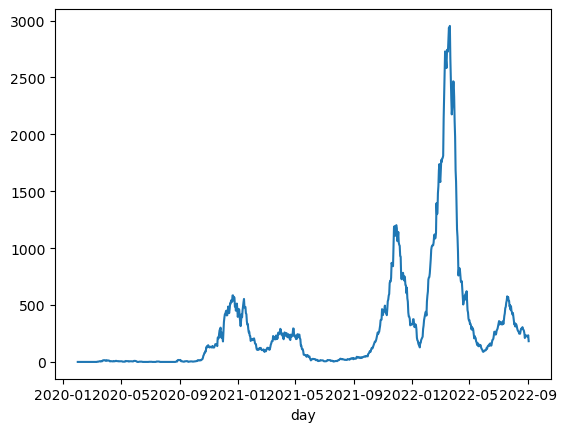

In [228]:
#df_train.value.plot()
#df_test.value.plot()
#df_test.set_index('day').value.plot()
df_train.set_index('day').value.plot()
df_train.tail()

In [37]:
query = """
    select * from covid_results_v5 crv 
    where crv.location like 'Berlin' 
    and crv.day between '2021-03-17' and '2021-05-15';
"""
cur.execute(query)
test_df = pd.DataFrame(cur.fetchall(), columns = ['day', 
                                             'location',
                                             'submitted_on',
                                             'ktot_1',
                                             'k2tot_1',
                                             'ndid_1',
                                             'npop_1',
                                             'pdid_1',
                                             'pping_1',
                                             'plink_1',
                                             'ktot_2',
                                             'k2tot_2',
                                             'ndid_2',
                                             'npop_2',
                                             'pdid_2',
                                             'pping_2',
                                             'plink_2',
                                             'k2tot_12',
                                             'stype_corrfac',
                                             '<k>',
                                             'CI(<k>)',
                                             '<k^2>',
                                             'CI(<k^2>)',
                                             'cx',
                                             'CI(cx)',
                                             'cx_excl_stadiums',
                                             'cx_only_stadiums'
])

print(len(test_df.columns), len(test_df))
test_df.head(5)

27 60


,day,location,submitted_on,ktot_1,k2tot_1,ndid_1,npop_1,pdid_1,pping_1,plink_1,...,k2tot_12,stype_corrfac,<k>,CI(<k>),<k^2>,CI(<k^2>),cx,CI(cx),cx_excl_stadiums,cx_only_stadiums
0,2021-03-17,Berlin,2022-08-11,1192,1476,13425,3292017,0.004078,0.006903,0.026645,...,0,0.953021,16.179354,0.984753,702.74945,137.195270,43.434950,11.123307,43.434950,0.0
1,2021-03-18,Berlin,2022-08-11,1093,1335,13420,3292017,0.004077,0.006996,0.026941,...,0,0.953101,14.683521,0.929441,586.41270,102.754486,39.936790,9.525873,39.936790,0.0
2,2021-03-19,Berlin,2022-08-11,1202,1546,13462,3292017,0.004089,0.006968,0.026851,...,0,0.953953,16.101212,0.995845,831.27130,171.063960,51.627872,13.817427,51.627872,0.0
3,2021-03-20,Berlin,2022-08-11,918,1124,12821,3292017,0.003895,0.006438,0.025160,...,0,1.002172,14.468341,1.004917,656.34296,128.756760,45.364080,12.050028,45.364080,0.0
4,2021-03-21,Berlin,2022-08-11,748,850,12255,3292017,0.003723,0.006146,0.024215,...,0,1.012062,13.406625,0.996311,401.82428,84.678420,29.972069,8.543532,29.972069,0.0


        location      target       value
290983   16077.0  2022-01-04  375.752637
290984   16077.0  2022-01-05  340.667300
290985   16077.0  2022-01-06  303.318394
290986   16077.0  2022-01-07  316.899814
290987   16077.0  2022-01-08  322.558740
target
2020-02-01         6.520770
2020-02-02         6.520770
2020-02-03         6.587965
2020-02-04         7.995626
2020-02-05         6.578827
                  ...      
2022-01-04    112765.223057
2022-01-05    121666.853585
2022-01-06    126345.060327
2022-01-07    133698.305399
2022-01-08    139095.625905
Name: value, Length: 708, dtype: float64


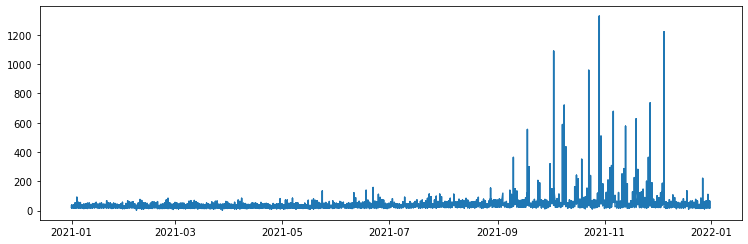

<AxesSubplot:xlabel='target'>

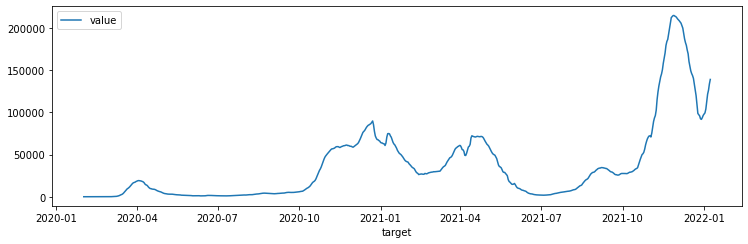

In [108]:
total_cases_df = pd.read_parquet(r'challenge-data/truth/2022-01-09_LK_cases.parquet' )

print(total_cases_df.tail())
vaccination_df = pd.read_excel('Impfquotenmonitoring.xlsx', 'Impfungen_proTag')

query = """
    select day,cx from covid_results_v5 crv  
    where crv.day between '2021-01-01' and '2021-12-31'; 
"""
cur.execute(query)
cx_df = pd.DataFrame(cur.fetchall(), columns = ['day','cx'])


total_cases_df = total_cases_df.groupby(['target']).value.sum()
print(total_cases_df)
#print(total_cases_df.groupby('target').sum().tail())
# vaccination_df_sliced = vaccination_df.loc[:635] #till 2022-09-23
# vaccination_df_sliced['Erste Impfung'].plot(legend=True)
plt.plot(cx_df.day,cx_df.cx)
plt.show()
total_cases_df.plot(legend=True)
#total_cases_df.plot(legend=True)

In [97]:
pip install pyarrow

Note: you may need to restart the kernel to use updated packages.


**Drop unwanted columns**

In [39]:
#df2 = df2.drop(['location', 'submitted_on', 'npop_1', 'npop_2', 'ndid_2'], axis=1)
test_df = test_df.drop(['location', 'submitted_on', 'npop_1', 'npop_2', 'ndid_2'], axis=1)
print(len(test_df.columns))

22


**Join the given time series to covid_results_v5 data with index as 'day'**

In [40]:
#df2=df2.set_index('day')
#combined_df = pd.concat([df2, train.value.to_frame()], axis=1)
#combined_df.columns
test_df=test_df.set_index('day')
combined_df_test = pd.concat([test_df, test.value.to_frame()], axis=1)

print(len(combined_df_test.columns), len(combined_df.columns))

22 22


C:\Users\nishant.nigam\AppData\Local\Temp\ipykernel_18360\1648575673.py:5: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  combined_df_test = pd.concat([test_df, test.value.to_frame()], axis=1)


In [41]:
complete_df = pd.concat([combined_df, combined_df_test], axis=0)
#complete_df.drop('ndid_2', axis=1)
combined_df.isnull().sum()
# values = {'a': 0, 'b': 1, 'c': 2, 'd': 3}
# s.fillna(value=values)
#combined_df.loc["2021-04-15"]

ktot_1              0
k2tot_1             0
ndid_1              0
pdid_1              0
pping_1             0
plink_1             0
ktot_2              0
k2tot_2             0
pdid_2              0
pping_2             0
plink_2             0
k2tot_12            0
stype_corrfac       0
<k>                 0
CI(<k>)             0
<k^2>               0
CI(<k^2>)           0
cx                  0
CI(cx)              0
cx_excl_stadiums    0
cx_only_stadiums    0
value               0
dtype: int64

**Find correlation between columns**

ktot_1             -0.195878
k2tot_1            -0.169638
ndid_1             -0.229974
pdid_1             -0.229974
pping_1             0.233118
plink_1             0.231502
ktot_2             -0.089953
k2tot_2            -0.074265
pdid_2             -0.224908
pping_2             0.051562
plink_2             0.047009
k2tot_12           -0.077406
stype_corrfac      -0.191938
<k>                -0.225345
CI(<k>)            -0.146958
<k^2>              -0.155831
CI(<k^2>)          -0.152131
cx                 -0.174823
CI(cx)             -0.162451
cx_excl_stadiums   -0.174224
cx_only_stadiums   -0.053073
value               1.000000
dtype: float64

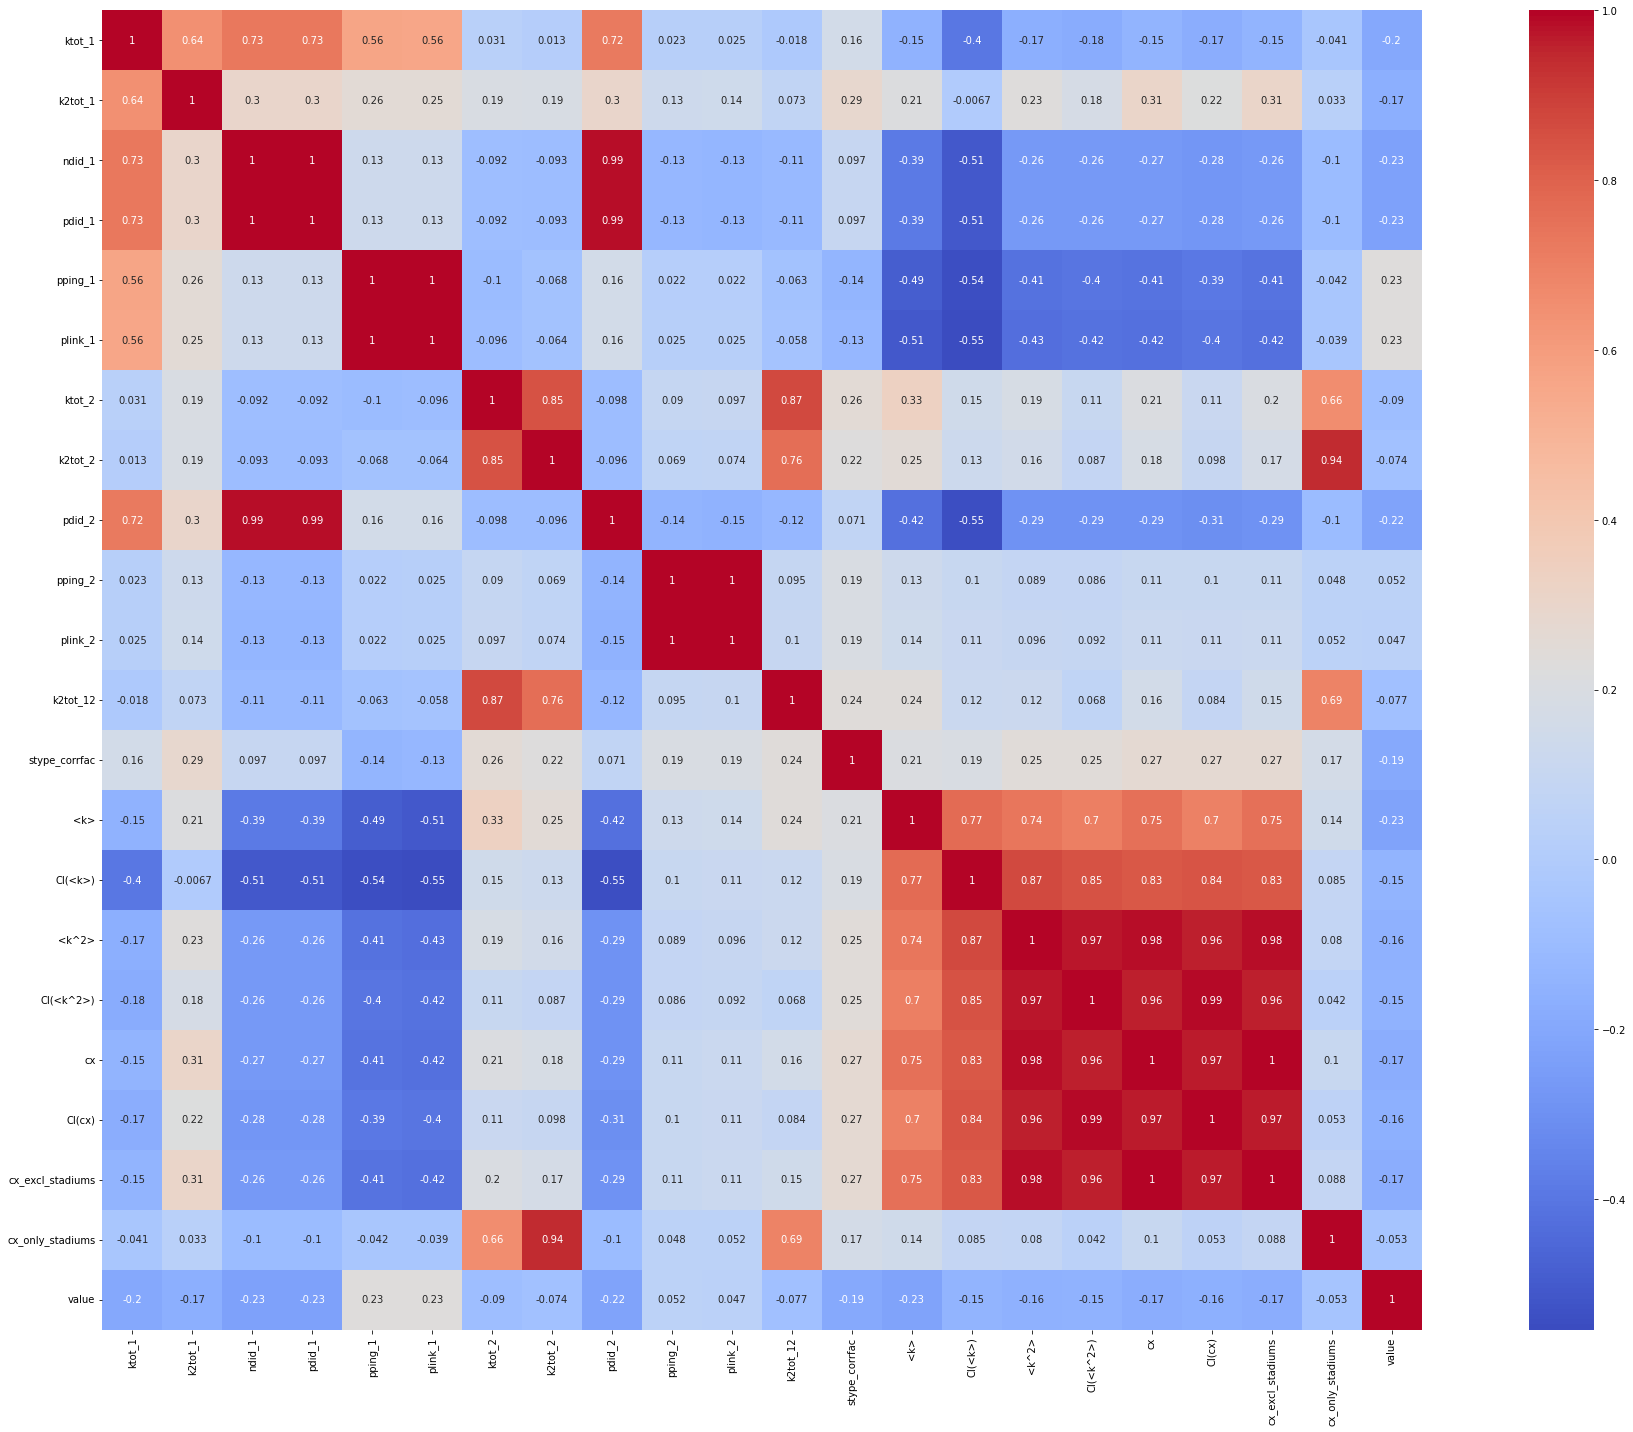

In [13]:
mask = np.zeros_like(combined_df.corr())
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(30, 20))
sns.heatmap(combined_df.corr(), annot = True, fmt='.2g',cmap= 'coolwarm', square=True)
combined_df.corrwith(combined_df.value)

(array([18701., 18708., 18718., 18725., 18732., 18739., 18748., 18755.,
        18762.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

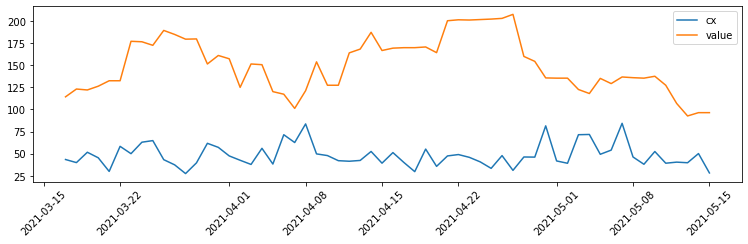

In [14]:
query = """
    select cx from covid_results_v5 crv 
    where crv.location like 'Berlin' 
    and crv.day between '2020-02-01' and '2021-03-16'; 
"""
cur.execute(query)
df2 = pd.DataFrame(cur.fetchall(), columns = ['day', 
                                             'location',
                                             'submitted_on',
                                             'ktot_1',
                                             'k2tot_1',
                                             'ndid_1',
                                             'npop_1',
                                             'pdid_1',
                                             'pping_1',
                                             'plink_1',
                                             'ktot_2',
                                             'k2tot_2',
                                             'ndid_2',
                                             'npop_2',
                                             'pdid_2',
                                             'pping_2',
                                             'plink_2',
                                             'k2tot_12',
                                             'stype_corrfac',
                                             '<k>',
                                             'CI(<k>)',
                                             '<k^2>',
                                             'CI(<k^2>)',
                                             'cx',
                                             'CI(cx)',
                                             'cx_excl_stadiums',
                                             'cx_only_stadiums'
])

print(len(df2.columns), len(df2))
df2.tail(5)
combined_df_test.cx.plot(legend=True)
combined_df_test.value.plot(legend=True)
plt.xticks(rotation=45)

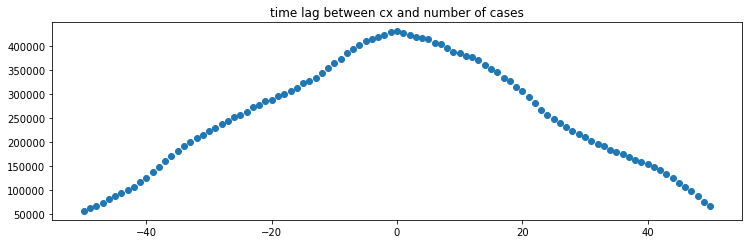

In [101]:
import numpy as np
import pandas as pd
import statsmodels
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import acf, pacf
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as ss

plt.xcorr(combined_df_test.cx, combined_df_test.value, normed=False, usevlines=False, maxlags=50)
plt.title("time lag between cx and number of cases")
plt.show()

In [89]:
combined_df_test.drop(['corr', 'correlation'], axis=1)

,ktot_1,k2tot_1,ndid_1,pdid_1,pping_1,plink_1,ktot_2,k2tot_2,pdid_2,pping_2,...,stype_corrfac,<k>,CI(<k>),<k^2>,CI(<k^2>),cx,CI(cx),cx_excl_stadiums,cx_only_stadiums,value
2021-03-17,1192,1476,13425,0.004078,0.006903,0.026645,0,0,0.005187,0.001230,...,0.953021,16.179354,0.984753,702.74945,137.195270,43.434950,11.123307,43.434950,0.0,114.261001
2021-03-18,1093,1335,13420,0.004077,0.006996,0.026941,0,0,0.005175,0.001481,...,0.953101,14.683521,0.929441,586.41270,102.754486,39.936790,9.525873,39.936790,0.0,123.070844
2021-03-19,1202,1546,13462,0.004089,0.006968,0.026851,0,0,0.005193,0.001282,...,0.953953,16.101212,0.995845,831.27130,171.063960,51.627872,13.817427,51.627872,0.0,122.002985
2021-03-20,918,1124,12821,0.003895,0.006438,0.025160,0,0,0.004993,0.001250,...,1.002172,14.468341,1.004917,656.34296,128.756760,45.364080,12.050028,45.364080,0.0,126.274424
2021-03-21,748,850,12255,0.003723,0.006146,0.024215,0,0,0.004838,0.000873,...,1.012062,13.406625,0.996311,401.82428,84.678420,29.972069,8.543532,29.972069,0.0,132.414618
2021-03-22,1072,1400,13048,0.003964,0.006770,0.026224,0,0,0.004996,0.000913,...,0.947729,15.650918,1.036468,912.54724,278.104340,58.306310,21.630486,58.306310,0.0,132.414618
2021-03-23,867,1057,12648,0.003842,0.005649,0.022583,0,0,0.004785,0.001637,...,0.946875,15.642798,1.116922,782.59680,194.791140,50.029205,16.024618,50.029205,0.0,176.997766
2021-03-24,1024,1352,12923,0.003926,0.006593,0.025657,0,0,0.004924,0.001770,...,0.950366,15.577513,1.062926,981.22830,232.145020,62.990047,19.200676,62.990047,0.0,176.463836
2021-03-25,1090,1472,13177,0.004003,0.006941,0.026767,0,0,0.004959,0.031548,...,0.954423,15.286908,1.021827,990.37350,280.729580,64.785730,22.694542,64.785730,0.0,172.459361
2021-03-26,1065,1313,13195,0.004008,0.006892,0.026609,0,0,0.004954,0.003312,...,0.955642,14.983866,0.965962,648.05000,135.203320,43.249850,11.811439,43.249850,0.0,189.278153


In [15]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

X_train, Y_train = combined_df.iloc[:,:20], combined_df.iloc[:,21]
X_test, Y_test = combined_df_test.iloc[:,:20], combined_df_test.iloc[:,21]
X_test.columns, Y_test

(Index(['ktot_1', 'k2tot_1', 'ndid_1', 'pdid_1', 'pping_1', 'plink_1', 'ktot_2',
        'k2tot_2', 'pdid_2', 'pping_2', 'plink_2', 'k2tot_12', 'stype_corrfac',
        '<k>', 'CI(<k>)', '<k^2>', 'CI(<k^2>)', 'cx', 'CI(cx)',
        'cx_excl_stadiums'],
       dtype='object'),
 2021-03-17    114.261001
 2021-03-18    123.070844
 2021-03-19    122.002985
 2021-03-20    126.274424
 2021-03-21    132.414618
 2021-03-22    132.414618
 2021-03-23    176.997766
 2021-03-24    176.463836
 2021-03-25    172.459361
 2021-03-26    189.278153
 2021-03-27    184.739749
 2021-03-28    179.400450
 2021-03-29    179.667415
 2021-03-30    151.369130
 2021-03-31    160.979868
 2021-04-01    157.242359
 2021-04-02    124.939599
 2021-04-03    151.369130
 2021-04-04    150.568235
 2021-04-05    120.134230
 2021-04-06    117.197615
 2021-04-07    101.179718
 2021-04-08    121.202090
 2021-04-09    153.771814
 2021-04-10    127.342284
 2021-04-11    127.342284
 2021-04-12    163.916483
 2021-04-13    168.1

In [19]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers import Dropout
from keras import optimizers

scaler = StandardScaler()

scaler.fit(combined_df)
scaled_train=scaler.transform(combined_df)
scaled_test=scaler.transform(combined_df_test)

n_input = 70
n_features = 22
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
#model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
opt = optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mse')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 100)               49200     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 49,301
Trainable params: 49,301
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.fit(generator, epochs=20)

Epoch 1/20
340/340 [==============================] - 4s 9ms/step - loss: 0.3230
Epoch 2/20
340/340 [==============================] - 3s 9ms/step - loss: 0.3175
Epoch 3/20
340/340 [==============================] - 3s 9ms/step - loss: 0.3156
Epoch 4/20
340/340 [==============================] - 3s 9ms/step - loss: 0.3150
Epoch 5/20
340/340 [==============================] - 3s 9ms/step - loss: 0.3141
Epoch 6/20
340/340 [==============================] - 3s 9ms/step - loss: 0.3129
Epoch 7/20
340/340 [==============================] - 3s 9ms/step - loss: 0.3128
Epoch 8/20
340/340 [==============================] - 3s 9ms/step - loss: 0.3123
Epoch 9/20
340/340 [==============================] - 3s 9ms/step - loss: 42893756.0000
Epoch 10/20
340/340 [==============================] - 3s 9ms/step - loss: 0.3122
Epoch 11/20
340/340 [==============================] - 3s 9ms/step - loss: 0.3115
Epoch 12/20
340/340 [==============================] - 3s 9ms/step - loss: 0.3110
Epoch 13/20
340/34

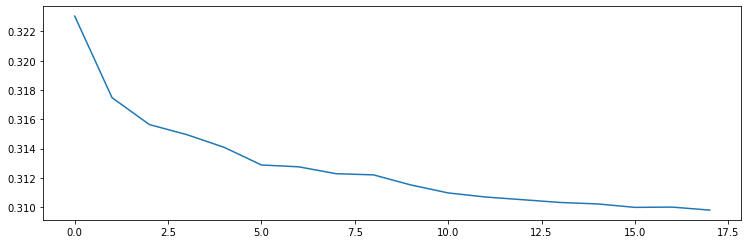

In [21]:
loss_per_epoch = model.history.history['loss']
loss_per_epoch.remove(max(loss_per_epoch))
loss_per_epoch.remove(max(loss_per_epoch))
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [22]:
pred = model.predict(scaled_test)
pred_Inverse = scaler.inverse_transform(pred)
pred_Inverse

ValueError: in user code:

    File "C:\Users\nishant.nigam\Anaconda3\lib\site-packages\keras\engine\training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\nishant.nigam\Anaconda3\lib\site-packages\keras\engine\training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\nishant.nigam\Anaconda3\lib\site-packages\keras\engine\training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\nishant.nigam\Anaconda3\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
        return self(x, training=False)
    File "C:\Users\nishant.nigam\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\nishant.nigam\Anaconda3\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_2" is incompatible with the layer: expected shape=(None, 70, 22), found shape=(None, 22)


In [20]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))
print(current_batch.shape)

print(type(current_batch), len(current_batch[0]))

for i in range(len(combined_df_test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)
    print(current_pred, current_pred[0])
    
    # append the prediction into the array
    test_predictions.append(current_pred[0]) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

(1, 60, 22)
<class 'numpy.ndarray'> 60
1/1 [==============================] - 0s 136ms/step
[[-0.3409474]] [-0.3409474]


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 1 has 4 dimension(s)

# Multivariate Time Series – Vector Auto Regression (VAR)

In [145]:
from statsmodels.tsa.vector_ar.var_model import VAR
for dataset in datasets:
    model = VAR(endog=dataset[0])
    model_fit = model.fit()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ValueError: Only gave one variable to VAR

In [40]:
prediction = model_fit.forecast(model_fit.endog, steps=len(scaled_test))
prediction[:,-1].shape

(30,)

In [41]:
from math import sqrt
from sklearn.metrics import mean_squared_error
sqrt(mean_squared_error(prediction[:, -1], test['value']))

40.64760605641379